<a href="https://colab.research.google.com/github/SreyaJampana/Cognitive-Distortion-Detection/blob/main/BERT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the oversampler
from imblearn.over_sampling import RandomOverSampler

# Step 1: Upload dataset
from google.colab import files
uploaded = files.upload()

import pandas as pd

# Step 2: Load the dataset
annotated_data = pd.read_csv('Annotated_data.csv')

# Step 3: Fill missing labels for "No distortion" to standardize the data
annotated_data['Dominant Distortion'].fillna('No distortion', inplace=True)

# Step 4: Preprocessing - Encode labels
def encode_labels(labels):
    unique_labels = sorted(set(labels))
    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    id_to_label = {idx: label for label, idx in label_to_id.items()}
    return [label_to_id[label] for label in labels], label_to_id, id_to_label

encoded_labels, label_to_id, id_to_label = encode_labels(annotated_data['Dominant Distortion'])
annotated_data['encoded_label'] = encoded_labels

# Step 5: Train-test split
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    annotated_data['Patient Question'].tolist(),
    annotated_data['encoded_label'].tolist(),
    test_size=0.2, random_state=42
)

# Step 6: Oversample the training set
ros = RandomOverSampler(random_state=42)
train_texts_resampled, train_labels_resampled = ros.fit_resample(pd.DataFrame(train_texts), pd.Series(train_labels))

# Convert back to lists for further processing
train_texts_resampled = train_texts_resampled[0].tolist()
train_labels_resampled = train_labels_resampled.tolist()

# Step 7: Tokenization
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_data(texts, labels, max_length=128):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    encodings['labels'] = labels
    return encodings

train_encodings = tokenize_data(train_texts_resampled, train_labels_resampled)
test_encodings = tokenize_data(test_texts, test_labels)

# Step 8: Prepare the dataset for PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

class CognitiveDistortionDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

train_dataset = CognitiveDistortionDataset(train_encodings)
test_dataset = CognitiveDistortionDataset(test_encodings)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Step 9: Load DistilBERT and prepare for fine-tuning
from transformers import DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_to_id)
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 4  # Assuming 4 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Step 10: Train the model
def train_model(model, train_loader, optimizer, scheduler, device, epochs=4):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

train_model(model, train_loader, optimizer, scheduler, device, epochs=4)

# Step 11: Evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

preds, true_labels = evaluate_model(model, test_loader, device)

# Step 12: Report performance
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds, target_names=list(label_to_id.keys())))

import os
import torch

# Create a directory to save the model and tokenizer in Colab
save_directory = './cognitive_distortion_model'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the model
model_save_path = os.path.join(save_directory, 'pytorch_model.bin')
torch.save(model.state_dict(), model_save_path)
print(f'Model saved at {model_save_path}')

# Save the tokenizer
tokenizer_save_path = os.path.join(save_directory, 'tokenizer')
tokenizer.save_pretrained(tokenizer_save_path)
print(f'Tokenizer saved at {tokenizer_save_path}')

Saving Annotated_data.csv to Annotated_data.csv


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4, Loss: 1.5498
Epoch 2/4, Loss: 0.1940
Epoch 3/4, Loss: 0.0351
Epoch 4/4, Loss: 0.0122
Accuracy: 0.33201581027667987
                         precision    recall  f1-score   support

All-or-nothing thinking       0.18      0.07      0.10        28
    Emotional Reasoning       0.00      0.00      0.00        28
        Fortune-telling       0.25      0.13      0.17        31
               Labeling       0.43      0.22      0.29        27
          Magnification       0.09      0.07      0.08        43
          Mental filter       0.25      0.07      0.11        30
           Mind Reading       0.29      0.15      0.20        47
          No Distortion       0.42      0.78      0.54       175
     Overgeneralization       0.12      0.09      0.10        46
        Personalization       0.07      0.03      0.04        32
      Should statements       0.33      0.11      0.16        19

               accuracy                           0.33       506
              macro avg    

In [ ]:
!ls ./cognitive_distortion_model/


pytorch_model.bin  tokenizer


In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader

from google.colab import files
uploaded = files.upload()

# Step 1: Load the new dataset
new_data = pd.read_csv('Suicide_Detection.csv')  # Adjust the filename

# Step 2: Tokenize the new text data using the saved tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('./cognitive_distortion_model/tokenizer')

def tokenize_data(texts, max_length=128):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    return encodings

new_texts = new_data['text'].tolist()  # Extract the text column
new_encodings = tokenize_data(new_texts)

# Step 3: Create a dataset class for the new data
class NewDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

new_dataset = NewDataset(new_encodings)
new_loader = DataLoader(new_dataset, batch_size=16, shuffle=False)

# Step 4: Load the trained cognitive distortion model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_to_id))
model.load_state_dict(torch.load('./cognitive_distortion_model/pytorch_model.bin'))
model.to(device)
model.eval()

# Step 5: Perform inference to predict cognitive distortions
predictions = []
with torch.no_grad():
    for batch in new_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())

# Convert predictions from numeric labels back to distortion names
predicted_labels = [id_to_label[pred] for pred in predictions]

# Step 6: Add the predictions to the original dataframe and save the result
new_data['predicted_distortion'] = predicted_labels
new_data.to_csv('new_data_with_cognitive_distortions.csv', index=False)

print("Predictions saved successfully!")

Saving Suicide_Detection.csv to Suicide_Detection.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions saved successfully!


In [ ]:
import pandas as pd

# Load the saved CSV file
new_data_with_distortions = pd.read_csv('new_data_with_cognitive_distortions.csv')

# Display the first few rows
new_data_with_distortions.head()

,Unnamed: 0,text,class,predicted_distortion
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,No Distortion
1,3,Am I weird I don't get affected by compliments...,non-suicide,Should statements
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,No Distortion
3,8,i need helpjust help me im crying so hard,suicide,Magnification
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,All-or-nothing thinking


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Unnamed: 0'].plot(kind='hist', bins=20, title='Unnamed: 0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('predicted_distortion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='Unnamed: 0', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('class')):
  _plot_series(series, series_name, i)
  fig.legend(title='class', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('predicted_distortion')):
  _plot_series(series, series_name, i)
  fig.legend(title='predicted_distortion', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unnamed: 0']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unnamed: 0'}, axis=1)
              .sort_values('Unnamed: 0', ascending=True))
  xs = counted['Unnamed: 0']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_10['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Unnamed: 0'].plot(kind='line', figsize=(8, 4), title='Unnamed: 0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['class'].value_counts()
    for x_label, grp in _df_12.groupby('text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('text')
_ = plt.ylabel('class')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['predicted_distortion'].value_counts()
    for x_label, grp in _df_13.groupby('class')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('class')
_ = plt.ylabel('predicted_distortion')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='index', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='index', y='class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['predicted_distortion'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='index', y='predicted_distortion', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='Unnamed: 0', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
from google.colab import files

# Download the file
files.download('new_data_with_cognitive_distortions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-10-ada5df7d6699>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='Blues_d')


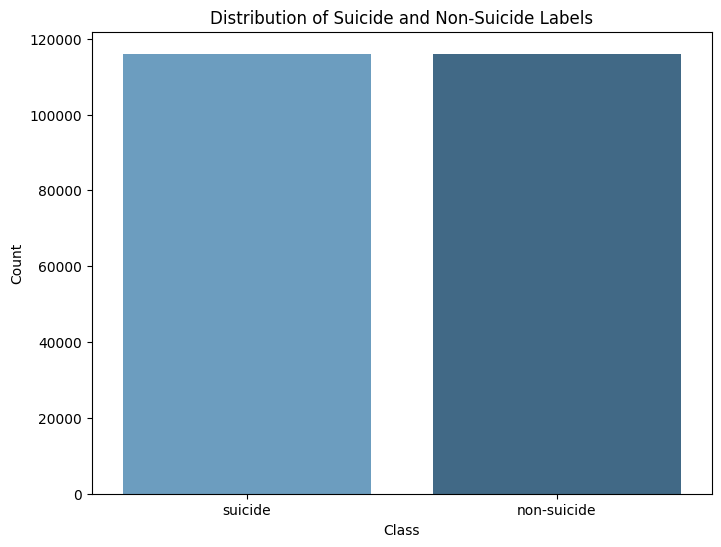

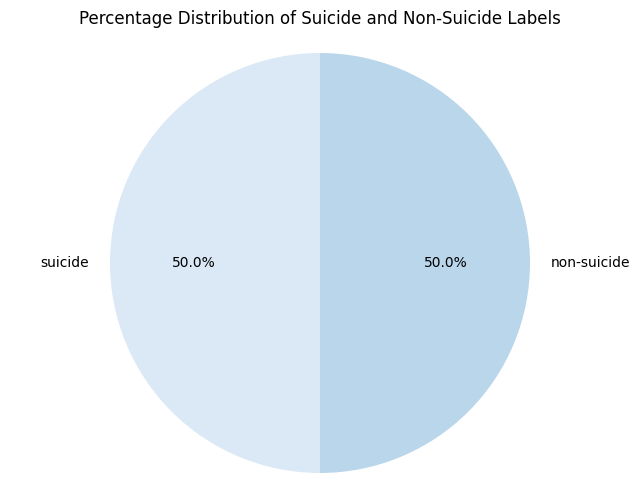

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (if it's not already loaded)
df = pd.read_csv('Suicide_Detection.csv')

# Count the occurrences of each class
class_counts = df['class'].value_counts()

# Plot the distribution as a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='Blues_d')
plt.title('Distribution of Suicide and Non-Suicide Labels')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Optional: Pie chart visualization
plt.figure(figsize=(8,6))
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Blues'))
plt.title('Percentage Distribution of Suicide and Non-Suicide Labels')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

<ipython-input-12-db82e1a9d92d>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distortion_counts.index, y=distortion_counts.values, palette='Reds_d')


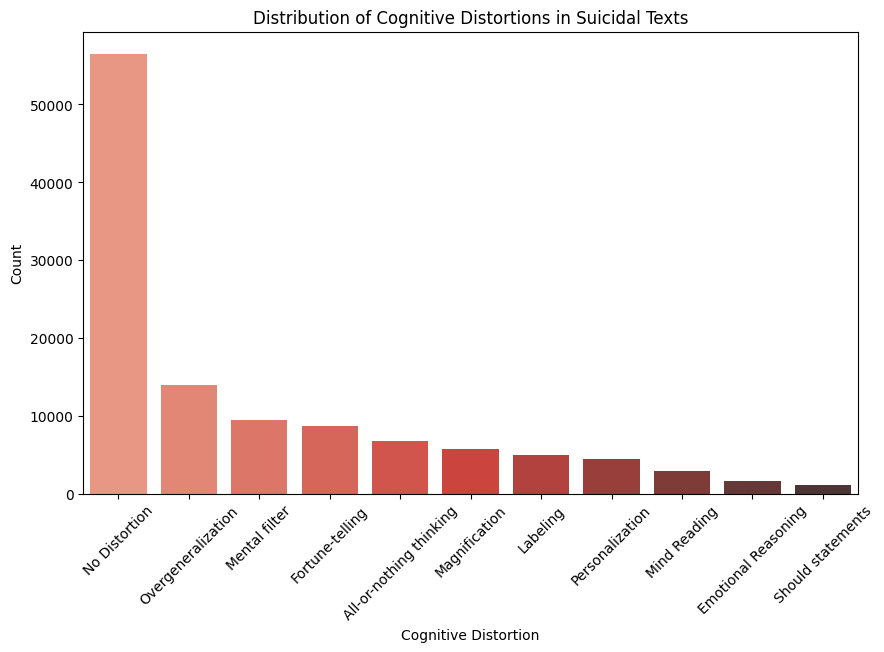

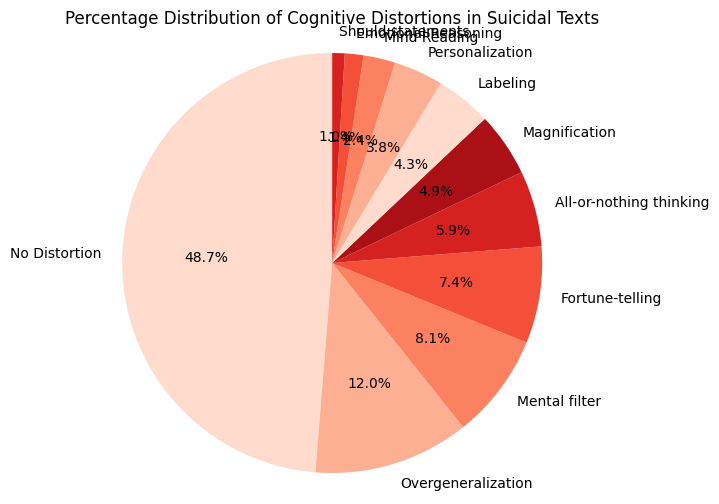

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the updated dataset with cognitive distortions (if not already loaded)
updated_df = pd.read_csv('new_data_with_cognitive_distortions.csv')

# Step 1: Filter the dataset for only 'suicidal' texts
suicidal_texts_df = updated_df[updated_df['class'] == 'suicide']

# Step 2: Count the occurrences of each cognitive distortion in 'suicidal' texts
distortion_counts = suicidal_texts_df['predicted_distortion'].value_counts()

# Step 3: Plot the distribution as a bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=distortion_counts.index, y=distortion_counts.values, palette='Reds_d')
plt.title('Distribution of Cognitive Distortions in Suicidal Texts')
plt.xlabel('Cognitive Distortion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Optional: Pie chart visualization
plt.figure(figsize=(8,6))
plt.pie(distortion_counts.values, labels=distortion_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Reds'))
plt.title('Percentage Distribution of Cognitive Distortions in Suicidal Texts')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

<Figure size 1200x700 with 0 Axes>

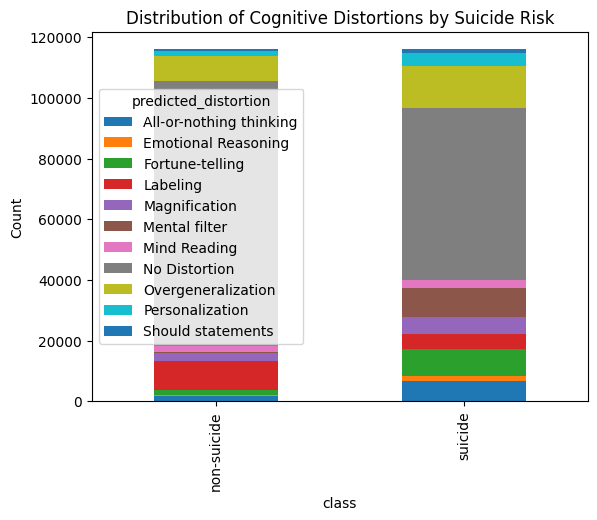

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


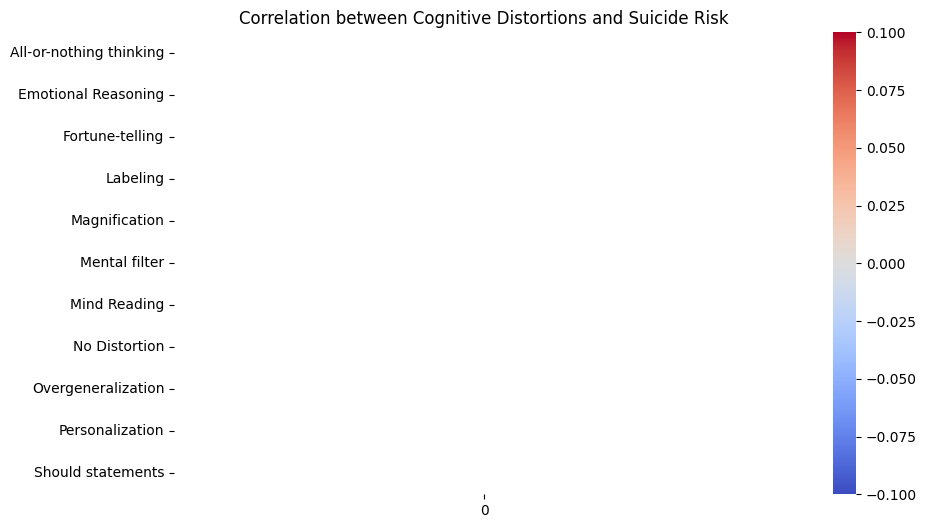

<Figure size 1200x700 with 0 Axes>

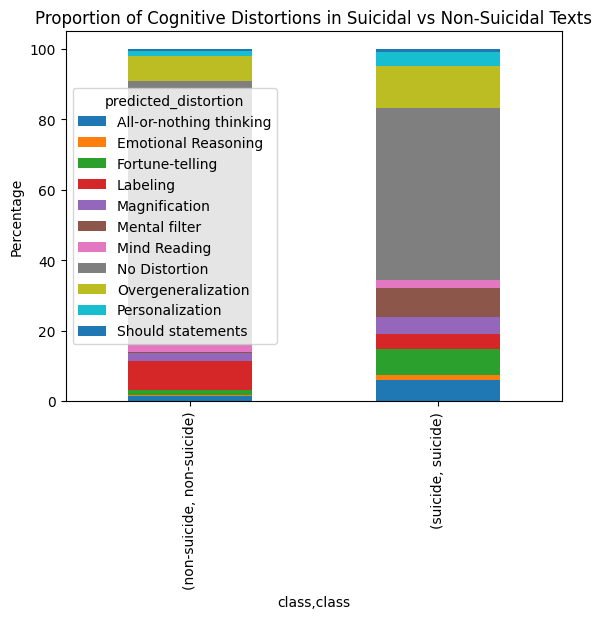

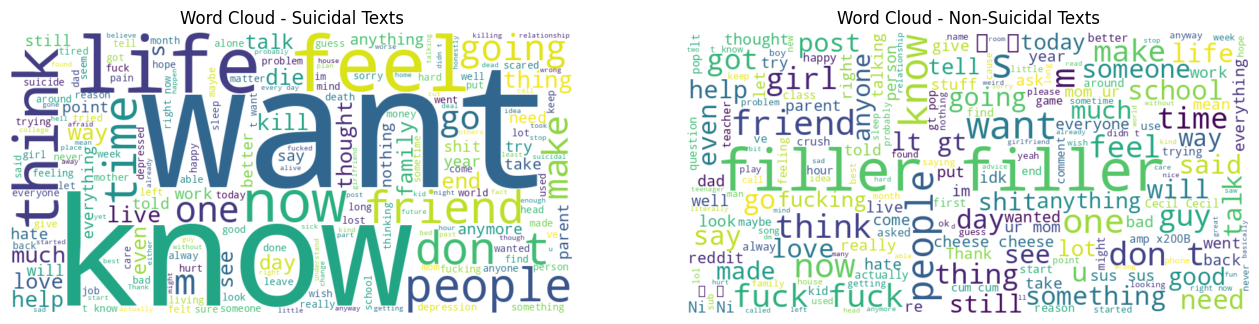

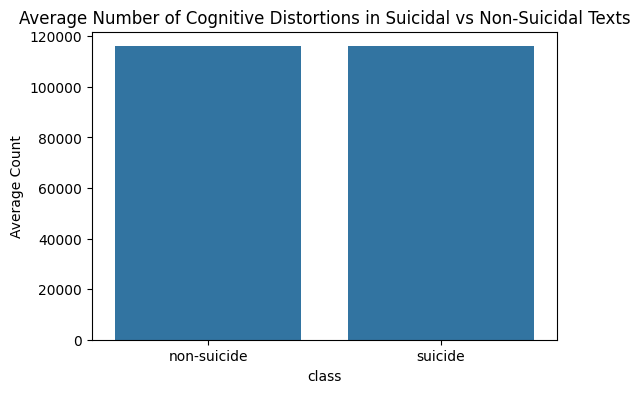

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from wordcloud import WordCloud

# Assuming your dataframe is named 'updated_suicide_detection'

### 1. Distribution of Cognitive Distortions by Suicide Risk

# Count cognitive distortions for each suicide class
distortion_by_risk = updated_df.groupby(['class', 'predicted_distortion']).size().unstack(fill_value=0)

# Plot the distribution
plt.figure(figsize=(12, 7))
distortion_by_risk.plot(kind='bar', stacked=True)
plt.title('Distribution of Cognitive Distortions by Suicide Risk')
plt.ylabel('Count')
plt.show()

### 2. Correlation Heatmap between Cognitive Distortions and Suicide Risk

# Convert cognitive distortion labels to binary format (one-hot encoding)
lb = LabelBinarizer()
distortion_binarized = lb.fit_transform(updated_df['predicted_distortion'])

# Convert suicide labels to binary
suicide_binarized = updated_df['class'].apply(lambda x: 1 if x == 'suicidal' else 0)

# Compute correlation matrix
correlations = pd.DataFrame(distortion_binarized, columns=lb.classes_).corrwith(suicide_binarized)

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation between Cognitive Distortions and Suicide Risk')
plt.show()

### 3. Pairplot of Cognitive Distortions vs Suicide Risk


### 4. Proportion of Cognitive Distortions in Suicidal vs Non-Suicidal Texts

# Calculate proportions of cognitive distortions in suicidal vs non-suicidal
distortion_proportions = updated_df.groupby(['class', 'predicted_distortion']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack(fill_value=0)

# Plot the proportions
plt.figure(figsize=(12, 7))
distortion_proportions.plot(kind='bar', stacked=True)
plt.title('Proportion of Cognitive Distortions in Suicidal vs Non-Suicidal Texts')
plt.ylabel('Percentage')
plt.show()

### 5. Word Cloud of Cognitive Distortion-Suicide Relationship

# Separate texts for suicidal and non-suicidal
suicidal_texts = new_data[new_data['class'] == 'suicide']['text']
non_suicidal_texts = new_data[new_data['class'] == 'non-suicide']['text']

# Create word clouds
suicidal_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(suicidal_texts))
non_suicidal_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_suicidal_texts))

# Plot word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(suicidal_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Suicidal Texts')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_suicidal_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Non-Suicidal Texts')
plt.axis('off')

plt.show()

### 6. Average Number of Cognitive Distortions in Suicidal vs Non-Suicidal Texts

# Compare the average number of cognitive distortions in each class
distortion_counts = updated_df.groupby('class')['predicted_distortion'].count()

# Plot the average count
plt.figure(figsize=(6, 4))
sns.barplot(x=distortion_counts.index, y=distortion_counts.values)
plt.title('Average Number of Cognitive Distortions in Suicidal vs Non-Suicidal Texts')
plt.ylabel('Average Count')
plt.show()


In [ ]:
print(annotated_data.head())

   Id_Number                                   Patient Question  \
0       4500  Hello, I have a beautiful,smart,outgoing and a...   
1       4501  Since I was about 16 years old I’ve had these ...   
2       4502   So I’ve been dating on and off this guy for a...   
3       4503  My parents got divorced in 2004. My mother has...   
4       4504  I don’t really know how to explain the situati...   

                                      Distorted part Dominant Distortion  \
0  The voice are always fimilar (someone she know...     Personalization   
1  I feel trapped inside my disgusting self and l...            Labeling   
2                                                NaN       No Distortion   
3                                                NaN       No Distortion   
4  I refused to go because I didn’t know if it wa...     Fortune-telling   

  Secondary Distortion (Optional)  encoded_label  
0                             NaN              9  
1             Emotional Reasoning     

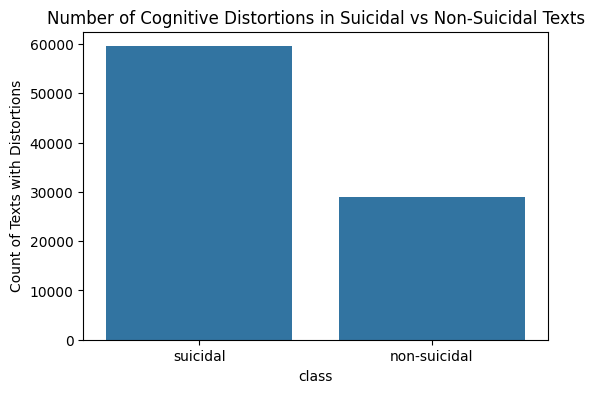

In [ ]:
distorted_suicidal = updated_df[(updated_df['class'] == 'suicide') & (updated_df['predicted_distortion'] != 'No Distortion')]
distorted_non_suicidal = updated_df[(updated_df['class'] == 'non-suicide') & (updated_df['predicted_distortion'] != 'No Distortion')]

# Count how many texts are labelled with cognitive distortions in each class
suicidal_distortion_count = len(distorted_suicidal)
non_suicidal_distortion_count = len(distorted_non_suicidal)

# Create a dataframe for plotting
distortion_data = pd.DataFrame({
    'class': ['suicidal', 'non-suicidal'],
    'distortion_count': [suicidal_distortion_count, non_suicidal_distortion_count]
})

# Plot the counts
plt.figure(figsize=(6, 4))
sns.barplot(x='class', y='distortion_count', data=distortion_data)
plt.title('Number of Cognitive Distortions in Suicidal vs Non-Suicidal Texts')
plt.ylabel('Count of Texts with Distortions')
plt.show()

   Id_Number                                   Patient Question  \
0       4500  Hello, I have a beautiful,smart,outgoing and a...   
1       4501  Since I was about 16 years old I’ve had these ...   
2       4502   So I’ve been dating on and off this guy for a...   
3       4503  My parents got divorced in 2004. My mother has...   
4       4504  I don’t really know how to explain the situati...   

                                      Distorted part Dominant Distortion  \
0  The voice are always fimilar (someone she know...     Personalization   
1  I feel trapped inside my disgusting self and l...            Labeling   
2                                                NaN       No Distortion   
3                                                NaN       No Distortion   
4  I refused to go because I didn’t know if it wa...     Fortune-telling   

  Secondary Distortion (Optional)  
0                             NaN  
1             Emotional Reasoning  
2                             Na

<ipython-input-24-009b6a3aaab0>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_distribution.index, y=label_distribution.values, palette="Blues_d")


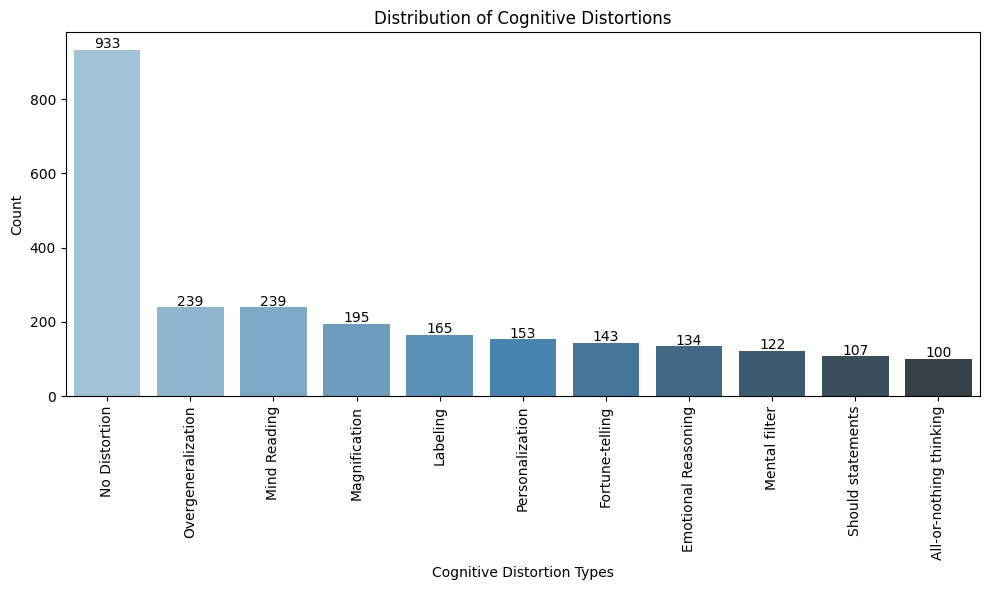

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (Assuming the file is in CSV format)
data = pd.read_csv('Annotated_data.csv')

# Check the first few rows to ensure it's loaded correctly
print(data.head())

# Count the distribution of 'Dominant Distortion' labels
label_distribution = data['Dominant Distortion'].value_counts()

# Print the distribution
print(label_distribution)

# Plot the distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=label_distribution.index, y=label_distribution.values, palette="Blues_d")

# Annotate each bar with the value count
for index, value in enumerate(label_distribution.values):
    ax.text(index, value + 5, str(value), color='black', ha="center")

plt.xticks(rotation=90)
plt.title('Distribution of Cognitive Distortions')
plt.ylabel('Count')
plt.xlabel('Cognitive Distortion Types')
plt.tight_layout()

# Show the plot
plt.show()

<ipython-input-3-6d66df5a7828>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


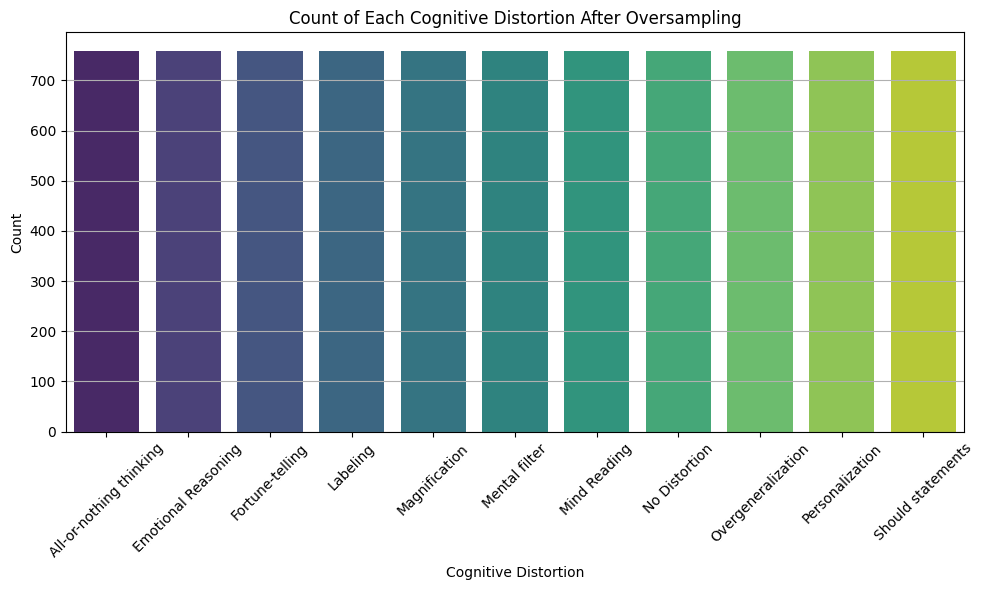

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each label after oversampling
import numpy as np

# Create a DataFrame for the resampled data
resampled_df = pd.DataFrame({'Patient Question': train_texts_resampled, 'Encoded Label': train_labels_resampled})

# Get the count of each label
label_counts = resampled_df['Encoded Label'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xticks(ticks=np.arange(len(label_to_id)), labels=list(label_to_id.keys()), rotation=45)
plt.title('Count of Each Cognitive Distortion After Oversampling')
plt.xlabel('Cognitive Distortion')
plt.ylabel('Count')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()